### Load speeches

In [102]:
import pandas as pd
import numpy as np
from nltk import sent_tokenize
from modules.nlputils import StemFilterTokenizeProcessor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

speeches_df = pd.read_csv('output/speeches/senate-speeches-201806.csv', index_col='CodigoPronunciamento')
speeches = speeches_df[['TextoIntegral']]
speeches = [s[0] for s in speeches.values[:]]

# labels = speeches_df[['NomeAutor']]
# labels = [s[0] for s in labels.values[:]]

speeches_df.head(1)

,TipoPronunciamento,Data,SiglaCasa,TipoSessao,NomeAutor,CodigoParlamentar,Partido,UF,SexoParlamentar,DataNascimentoParlamentar,Indexacao,TextoIntegral
CodigoPronunciamento,,,,,,,,,,,,
446075,Pronunciamento,2018-06-01,SF,NDL,Roberto Requião,72,MDB,PR,Masculino,1941-03-05,"CRITICA, GESTÃO, GOVERNO FEDERAL, MICHEL TEMER...",O SR. ROBERTO REQUIÃO (Bloco Maioria/MDB...


### TSNE Sents Clustering Visualization

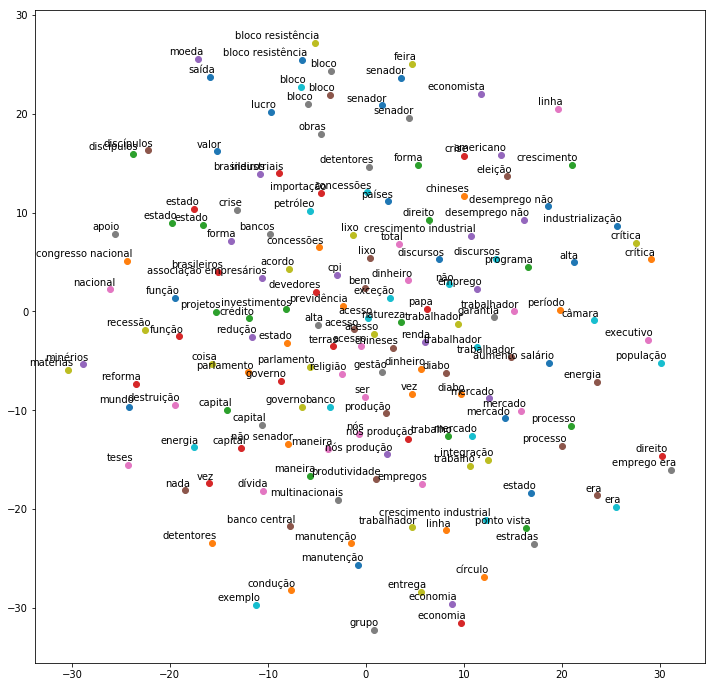

In [182]:
sents = sent_tokenize(speeches[0])
sents = [s for s in sents if len(s)>60]

#     stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
stopwords = []

proc = StemFilterTokenizeProcessor(min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)
vec = TfidfVectorizer(min_df=0.01, stop_words=stopwords, analyzer='word', ngram_range=(1, 2), preprocessor=proc.process_text)
X = vec.fit_transform(sents)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X.toarray())

%matplotlib inline
from matplotlib import pyplot as plt
x = []
y = []
for value in X_2d:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(12, 12)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])

    #show central keyword as label
    xx = X.toarray()[i]
    ti = np.argmax(xx)
    keyword = vec.get_feature_names()[ti]

    plt.annotate(keyword,
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

### K-Means clustering

In [221]:
from sklearn.metrics import pairwise_distances_argmin_min

sents = sent_tokenize(speeches[1])
sents = [s for s in sents if len(s)>60]
print(np.shape(sents))
#     stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
stopwords = []

proc = StemFilterTokenizeProcessor(min_size=4, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)
vec = TfidfVectorizer(min_df=0.01, stop_words=stopwords, analyzer='word', ngram_range=(1, 2), preprocessor=proc.process_text)
X = vec.fit_transform(sents)
print(np.shape(X))

n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters)
y_kmeans = kmeans_model.fit_predict(X)


avg = []
for j in range(n_clusters):
    idx = np.where(kmeans_model.labels_ == j)[0]
#     print(idx)
    avg.append(np.mean(idx))
#     print(str(np.mean(idx)))
print(np.shape(kmeans_model.cluster_centers_))
closest, _ = pairwise_distances_argmin_min(kmeans_model.cluster_centers_, X)
# print(closest)
ordering = sorted(range(n_clusters), key=lambda k: avg[k])
summary = ' '.join([sents[closest[idx]] for idx in ordering])
print(summary)


(173,)
(173, 175)
(2, 175)
Não são os mesmos corruptos que mantinham os diretores da Petrobras? Não são os mesmos corruptos que mantinham os diretores da Petrobras?


In [212]:
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
cluster_labels = []
for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    gl = "Cluster {}: ({})".format(i, ' '.join(top_words))
    cluster_labels.append(gl)

for i, sent in enumerate(sents):
    print('========')
    print(cluster_labels[y_kmeans[i]] + ' ' + sent)

Cluster 0: (bloco bloco resistência resistência senador greve)      O SR. PAULO PAIM  (Bloco Parlamentar da Resistência Democrática/PT - RS.
Cluster 2: (governo projeto país mercado política) É uma satisfação ver o retorno de V. Exª à Casa, já presidindo a sessão.
Cluster 2: (governo projeto país mercado política) No período em que V. Exª esteve aqui, com certeza, foi um dos mais presentes.
Cluster 2: (governo projeto país mercado política) Eu digo: bom, façam uma pesquisa e vejam a presença dos Senadores de segunda a sexta aqui na Casa.
Cluster 2: (governo projeto país mercado política) E V. Exª, com certeza, vai estar entre os que mais estiveram presentes durante o período em que esteve aqui.
Cluster 3: (senador falar presidente tempo tema) V. Exª está presidindo a sessão neste momento, substituindo o Senador Telmário Mota, que é candidato a governador no seu Estado.
Cluster 3: (senador falar presidente tempo tema) Ontem, eu estava casualmente presidindo, e, inclusive, ele fez um dis